### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

Reason → Act → Observe → Repeat

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)



## ⚙️ Execution Example

### 🧩 Query
> “Provide the top 10 AI news for March 3rd 2025, add 5 plus 5, and then multiply by 10.”

---

### 🧠 Flow Diagram

Human Query  
⬇️  
━━━━━━━━━━━━━━━━━━━  
🟪 **LLM Node**  
━━━━━━━━━━━━━━━━━━━  
   ├── 🤔 **Decides:** Needs external info  
   │        ⬇️  
   │     🧰 **Call Tool:** TavilySearch  
   │        ⬇️  
   │     📄 **Returns:** Top 10 AI news  
   │  
   ├── 🧮 **Observes:** Math task detected  
   │        ⬇️  
   │     🔢 **Call Tool:** Add(5 + 5)  
   │        ⬇️  
   │     ✅ **Result:** 10  
   │        ⬇️  
   │     ✖️ **Call Tool:** Multiply(10 × 10)  
   │        ⬇️  
   │     ✅ **Result:** 100  
   │  
⬇️  
━━━━━━━━━━━━━━━━━━━  
🧠 **LLM Final Reasoning**  
━━━━━━━━━━━━━━━━━━━  
⬇️  
📦 **Final Output**  
➡️ “Here are the top 10 AI news for March 3rd 2025, and the computed result is **100**.”


In [32]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [33]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [34]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [35]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [36]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [37]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [38]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [39]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [40]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'GPT 4.5 is out! — Weekly AI Newsletter (March 3rd 2025) - Medium',
  'url': 'https://medium.com/nlplanet/gpt-4-5-is-out-weekly-ai-newsletter-march-3rd-2025-6b31dd83ca60',
  'content': 'Anthropic releases Claude 3.7 Sonnet, OpenAI expands Deep Research for Plus users, and Google launches new code assistant.',
  'score': 0.9020676},
 {'title': 'AI round-up: Week of March 3, 2025 - Akhia',
  'url': 'https://www.akhia.com/insights/benthinking/ai-round-up-week-of-march-03-2025',
  'content': "Exploring the latest in AI advancements and ethical challenges, from Google's AI-only search to new AI models and the implications of unfiltered AI.",
  'score': 0.885404},
 {'title': 'Weekly AI News: 3 March 2025 - AIforBusiness.net - YouTube',
  'url': 'https://www.youtube.com/watch?v=kw21NJ7YmZM',
  'content': "Subscribe to our newsletter: http://eepurl.com/iNfyac This week's AI update explores some of the most impactful developments shaping",
  'score': 0.8415267},
 {'title': 'The Lates

In [41]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [42]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools=llm.bind_tools(tools)

In [43]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'n24cse67e', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 744, 'total_tokens': 764, 'completion_time': 0.033880667, 'prompt_time': 0.043339796, 'queue_time': 0.044516064, 'total_time': 0.077220463}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2c9e9238-c3ce-4b7e-b992-ea5493bc09ef-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'n24cse67e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 744, 'output_tokens': 20, 'total_tokens': 764})

In [44]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Recent AI News'},
  'id': '2s3k8kdaa',
  'type': 'tool_call'}]

In [45]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

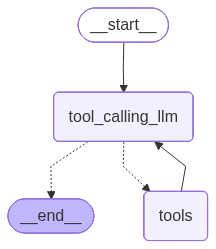

In [46]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [47]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (hf1qm9ze3)
 Call ID: hf1qm9ze3
  Args:
    query: AI news March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weekly AI News: 3 March 2025 - AIforBusiness.net - YouTube", "url": "https://www.youtube.com/watch?v=kw21NJ7YmZM", "content": "This week’s AI update explores some of the most impactful developments shaping technology and society. OpenAI has unveiled GPT-4.5, a cutting-edge model with enhanced intuition and emotional intelligence. While its capabilities push AI closer to human-like perception, its high computational demands raise concerns about accessibility, particularly for smaller businesses. [.

In [48]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (5dftahq07)
 Call ID: 5dftahq07
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================
Tool Calls:
  wikipedia (q4j47xn34)
 Cal

### Agent Memory
#### Aim
Lets introduce Agent With Memory

In [49]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (gqt92871r)
 Call ID: gqt92871r
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The answer to 5 plus 8 is 13.


In [50]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

<divide>{"a": "that", "b": 5}</divide>


# 1️⃣ What is MemorySaver?

Think of **MemorySaver** as a diary for your **LangGraph agent**.

Normally, each time the agent gets a message, it processes it and **forgets everything from before**.

**MemorySaver** changes that. It **remembers every step** by saving the graph state in memory.

This way, the agent can continue a conversation or computation **without losing track of what happened before**.

---

# 2️⃣ How it works (simple analogy)

Imagine you are solving a multi-step math problem:

1. **Add 5 + 8** → write result **13** in your notebook.  
2. **Later, divide that result by 5** → check your notebook to see the last number (**13**) and compute **13 / 5**.  
3. **Then multiply the result by 2** → again, pick up the last number from the notebook.  

💡 Without a memory, the agent would **forget 13 after step 1**.  
💡 With **MemorySaver**, it’s like having a notebook that **automatically saves every result**.


In [59]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize Groq LLM
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=os.getenv("GROQ_API_KEY"))

# Bind your tools
llm_with_tools = llm.bind_tools(tools)


In [60]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")


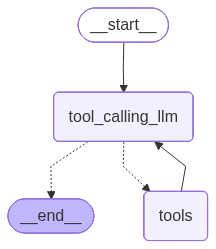

In [61]:
from langgraph.checkpoint.memory import MemorySaver

# MemorySaver keeps track of graph state
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# Optional: View graph
display(Image(graph_memory.get_graph().draw_mermaid_png()))


In [62]:
# Thread config
config = {"configurable": {"thread_id": "1"}}

# Step 1
messages = [HumanMessage(content="Add 12 and 13.")]
messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

# Step 2
messages = [HumanMessage(content="Add that number to 25")]
messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

# Step 3
messages = [HumanMessage(content="Then multiply that number by 2")]
messages = graph_memory.invoke({"messages": messages}, config=config)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (6kn069fya)
 Call ID: 6kn069fya
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of the function call was 25.
================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (6kn069fya)
 Call ID: 6kn069fya
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of the function call was 25.
================================ Human Message =======